# Phylogeographic Temporal Analysis

PTA is what you get when you put a bunch of momi and dadi inference together.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import ipyparallel as ipp
import matplotlib.pyplot as plt
import momi
import numpy as np
import os
import pandas as pd
import time

from IPython.display import display

import PTA


/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# ipcluster start --n=4 --cluster-id="PTA" --daemonize
ipyclient = ipp.Client(cluster_id="PTA")
len(ipyclient)

4

# Simulate
Make a simple demographic model, plot the default parameters and generate a couple quick simulations.

In [3]:
model = PTA.DemographicModel("watdo")
print(model.get_params())
msfs_list = model.serial_simulate(nsims=2, quiet=False, verbose=False)

------- PTA params file (v.0.0.9)-----------------------------------------------
watdo                ## [0] [simulation_name]: The name of this simulation scenario
./default_PTA        ## [1] [project_dir]: Where to save files
10                   ## [2] [npops]: Number of populations undergoing co-demographic processes
4                    ## [3] [nsamps]: Numbers of samples for each populations
                     ## [4] [N_e]: Effective population size of the ancestral population
                     ## [5] [tau]: Time of demographic change
                     ## [6] [epsilon]: Magnitude of demographic change
1000                 ## [7] [length]: Length in bp of each indpendent genomic region to simulate
100                  ## [8] [num_replicates]: Number of genomic regions to simulate
1e-09                ## [9] [recoms_per_gen]: Recombination rate within independent regions scaled per base per generation
1e-08                ## [10] [muts_per_gen]: Mutation rate scaled per bas

# Look at the results
Look at some pre-baked simulation results. Here the only "parameters" so far are zeta (proportion of co-expanding taxa) and psi (. 

There's an internal switch to enable/disable multiple coexpansion events, and here you can see for these simulations that it was enabled (psi can take values > 1). The rest of all the output are the SFS bins in momi format.

In [13]:
sim_df = pd.read_csv("../PTA/default_PTA/1000_loci-SIMOUT.csv", sep=" ")
sim_df.head()

,zeta,psi,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
0,0.842,3,74,146,321,62,142,343,100,170,...,281,36,80,247,51,115,329,78,152,313
1,0.921,4,86,153,301,60,132,318,96,145,...,287,73,145,350,72,143,339,91,131,330
2,0.929,2,75,169,341,104,161,339,85,197,...,292,50,112,316,50,110,297,27,87,229
3,0.446,1,13,47,158,11,39,162,12,41,...,347,121,175,373,119,188,407,102,168,353
4,0.612,2,46,94,325,51,105,265,127,181,...,267,54,90,320,160,187,409,101,204,350


# Some simple plotting routines
You can plot the mSFS on the first two PCs. The 'target' parameter specifies whether to color the points by 'psi' or by 'zeta' values.

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


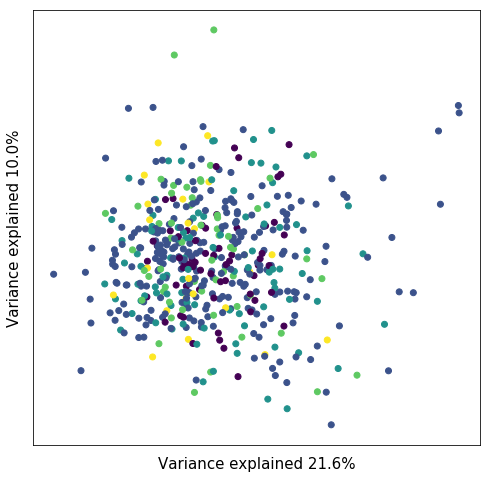

In [23]:
sim_df = pd.read_csv("../PTA/default_PTA/SIMOUT.csv", sep=" ").head(500)
PTA.plotting.plot_simulations_pca(sim_df, target="psi")

You can also plot histograms of all the parameters. This is kind of like the "priors".

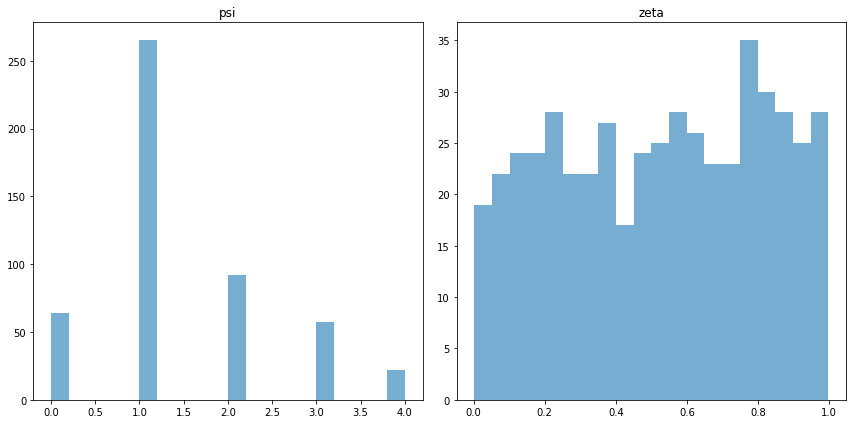

In [26]:
axs = PTA.plotting.plot_simulations_hist(sim_df)

# ML Inference
Now comes the fun part. 
## Prep the data


In [32]:
## Prep the data
## Just take the first one as the pseudo-observed data
true_parameters = pd.DataFrame(sim_df.loc[0]).T[["zeta", "psi"]]
empirical_df = pd.DataFrame(sim_df.loc[0]).T.drop(["zeta", "psi"], axis=1)
display(empirical_df)
tmp_df = sim_df.drop([0])
print(true_parameters)

,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],pop2-[[3_1]],pop3-[[1_3]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
0,12.0,23.0,27.0,18.0,19.0,24.0,11.0,22.0,43.0,5.0,...,53.0,11.0,12.0,26.0,15.0,27.0,51.0,12.0,13.0,34.0


    zeta  psi
0  0.333  1.0


# Cross-validation on classification of Psi
In that psi is _kind of_ ordinal data, we can do model classification cross-validation. This will do by default 5-fold cross-validation, but you can tune that if you want.

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/isaac/PTA/PTA/inference.py:375: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_model.fit(self.X, self.y)
/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


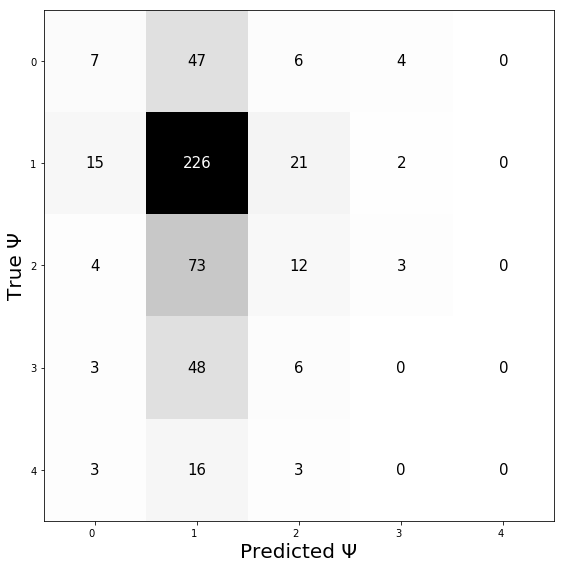

In [35]:
cla = PTA.inference.classification_cv(sim_df)
ax = cla.plot_confusion_matrix()

# Cross-validation on estimation of parameters
Here we can do 5-fold cross validation on parameter estimation. Whether psi is a 'model' or a 'parameter' is somewhat arguable, probably it's a 'model' because fractional psi values don't make sense.

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


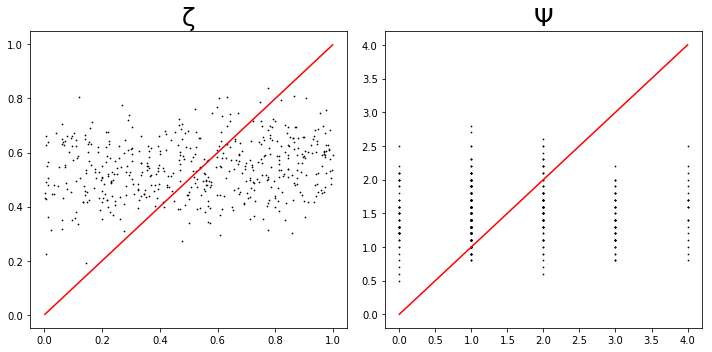

In [36]:
cla = PTA.inference.parameter_estimation_cv(sim_df)
ax = cla.plot_cv_predictions(figdims=(1,2))

# Perform Psi classification
Now this is classic model selection. We're using just one random simulation peeled off from the pack as the pseudo-observed data.

In [30]:
cla = PTA.inference.Classifier(empirical_df=empirical_df, sims=tmp_df, verbose=False)
est, proba = cla.predict(select_features=False, param_search=False, quick=True, verbose=True)

Predict() started: 2019-10-02 11:05:53.782787
Predict() finished: 2019-10-02 11:05:53.909667


/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/isaac/PTA/PTA/inference.py:375: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_model.fit(self.X, self.y)


## Look at classification results
Here we show the true 'known' psi, the estimate, and probability weights. We can also examine the feature importances, which show whether there are any mSFS bins that contribute more to information on psi.

'True psi 1.0'

,psi
estimate,3


,0,1,2,3,4
psi,0.1,0.3,0.2,0.4,0.0


,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],pop2-[[3_1]],pop3-[[1_3]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
Feature importance,0.035303,0.034631,0.036772,0.045525,0.02755,0.032227,0.024572,0.038946,0.034886,0.032323,...,0.031216,0.018681,0.024198,0.030945,0.032812,0.03308,0.055254,0.037195,0.038322,0.032474


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08845745f8>]],
      dtype=object)

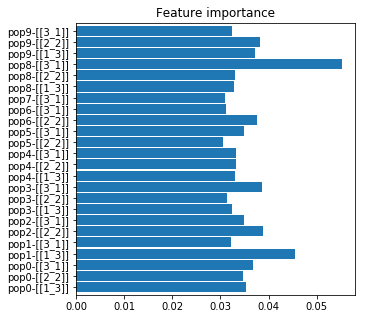

In [36]:
display("True psi = {}".format(true_parameters["psi"].values[0]), est, proba)
display(cla.feature_importances())
cla.plot_feature_importance(figsize=(5,5), cutoff=0.03)

# Perform ML Regression for parameter estimation
Now this is classic parameter estimation. We're using the same random simulation peeled off from the pack as the pseudo-observed data.

In [37]:
rgr = PTA.inference.Regressor(empirical_df=empirical_df, sims=tmp_df)
est = rgr.predict(select_features=False, param_search=False, quick=True, verbose=False)

In [38]:
print(true_parameters)
display(est)

    zeta  psi
0  0.333  1.0


,zeta,psi
estimate,0.5149,1.1
lower 0.025,0.0270,0.0
upper 0.975,0.9680,3.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0884441550>],
      dtype=object)

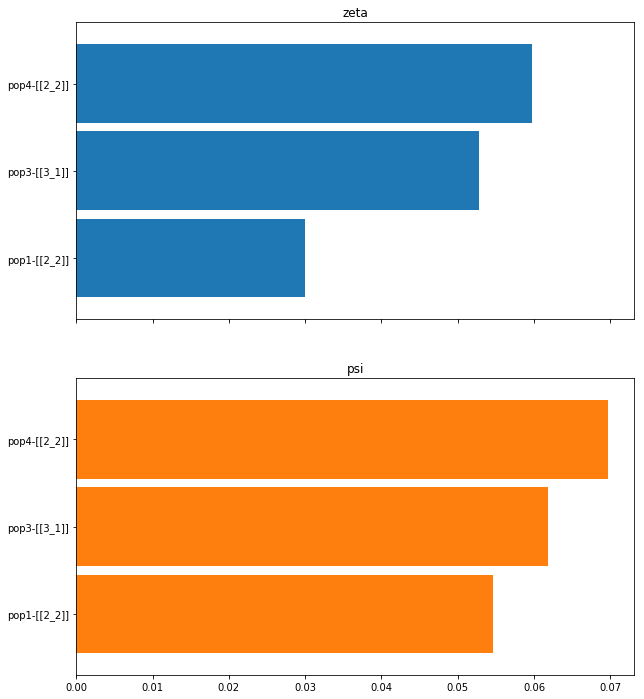

In [39]:
rgr.plot_feature_importance()

# Trash below here

# Build a demographic model

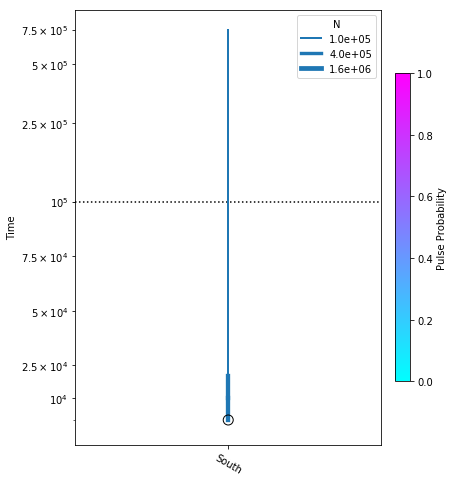

In [33]:
model = momi.DemographicModel(N_e=1e6)
model.add_leaf("South")
#model.add_time_param("texp")
model.set_size("South", t=20000, N=1e5)

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, 
    ["South"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5)

In [1069]:
## Simulated empirical

def get_sfs(name, N_e=1e6, t=20000, exp_magnitude=10, verbose=False):
    model = momi.DemographicModel(N_e=N_e)
    model.add_leaf(name)
    model.set_size(name, t=t, N=N_e/exp_magnitude)
    sampled_n_dict={name:4}
    if verbose: print(sampled_n_dict)
    ac = model.simulate_data(length=100,
                            num_replicates=100,
                            recoms_per_gen=1e-9,
                            muts_per_gen=1e-8,
                            sampled_n_dict=sampled_n_dict)
    return ac.extract_sfs(n_blocks=1)

south_sfs = get_sfs("South")
north_sfs = get_sfs("North")
central_sfs = get_sfs("Central", exp_magnitude=1)
np.array([south_sfs.loc_counts, central_sfs.loc_counts, north_sfs.loc_counts])

array([[[  9.,  51.,  15.]],

       [[378., 122., 220.]],

       [[ 21.,  54.,  13.]]])

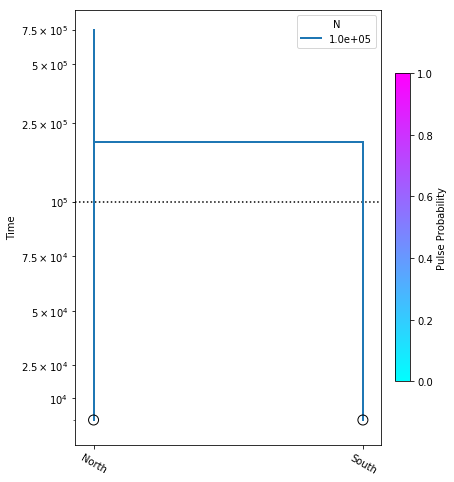

In [3]:
model = momi.DemographicModel(N_e=1e5)
model.add_leaf("North")
model.add_leaf("South")
model.move_lineages("South", "North", t=2e5)

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, 
    ["North", "South"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5)

In [13]:
sampled_n_dict={"North":4, "South":4}
ac = model.simulate_data(length=100,
                    num_replicates=1000,
                    recoms_per_gen=1e-9,
                    muts_per_gen=1e-8,
                    sampled_n_dict=sampled_n_dict)

In [43]:
imps = cla.feature_importances()
display(imps)
imps = imps[imps.columns[imps.max() > 0.0]]

,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],pop2-[[3_1]],pop3-[[1_3]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
Feature importance,0.032729,0.034168,0.038152,0.030881,0.036986,0.040976,0.033452,0.034764,0.033924,0.03247,...,0.032149,0.029115,0.030943,0.035424,0.027655,0.030318,0.033001,0.030367,0.030545,0.034648


NameError: name 'cutoff' is not defined